In [51]:
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import os
import re
import seaborn as sns
import random
import copy 
from util import *
import cv2
import statistics
from collections import Counter

from landscape import Landscape
from util import Type

In [102]:
def generateRoadAngleBars(folderpaths):
    b1 = []
    b2 = []
    b3 = []
    bb1 = []
    bb2 = []
    bb3 = []

    for folderpath in folderpaths:
        for _, _, filenames in os.walk(folderpath):
            lengths = []
            filenames = [f for f in filenames if f.endswith(".p")]
            
            list_of_degrees_mi = []
            list_of_degrees_ma = [] 

            for f in filenames:
                f = f[:f.index(".p")]
    #             print ("Filename = {}.".format(f))

                filename_state = "{}/{}.p".format(folderpath, f)
                filename_roads = "{}/{}.output.txt".format(folderpath, f)
                filename_stats = "{}/stats_{}.output.txt".format(folderpath, f)

                landscape = Landscape(100, 100, None, 0, 0, 0, 0, load_filename=filename_state) #hard-code size=100
                landscape.set_adjacents()

                list_of_roads = []
                roadnodes = set(copy.copy(landscape.roads))
                for n in sorted(landscape.roads, key=lambda x: (x.x, x.y)):
                    if n not in roadnodes:
                        continue
                    new_road = set([n])
                    new_road_bits = [x for nn in new_road for x in nn.adjacent if len(nn.adjacent & set(landscape.roads)) <= 2 and x in landscape.roads and x not in new_road]
                    while len(new_road_bits) > 0:
                        new_road.update(set(new_road_bits))
                        new_road_bits = [x for nn in new_road_bits for x in nn.adjacent if len(nn.adjacent & set(landscape.roads)) <= 2 and x in landscape.roads and x not in new_road]
                    list_of_roads.append(new_road)
                    roadnodes -= set(new_road)

                for road in list_of_roads:
                    road = list(road)
                    if len(road) >= 2:
                        # sort roadnodes of road according to x val
                        road = sorted(road, key=lambda x: (x.x, x.y))
                        rnode1 = road[0]
                        rnode2 = road[len(road)-1]
                        (x, y) = (rnode2.x - rnode1.x, rnode2.y - rnode1.y)

                        r = math.hypot(x, y)
                        theta = np.arctan2(y, x)
                        theta = math.degrees(theta) % 180
                        if theta == 0:
                            theta = 180
                        
                        lengths.append(r)
                            
                        if len(road) > 2:                            
                            if Type.MINOR_ROAD in road[-2].type:
                                list_of_degrees_mi.append((r, theta))
                            else:
                                list_of_degrees_ma.append((r, theta))
                        else:
                            if Type.MINOR_ROAD in rnode1.type or Type.MINOR_ROAD in rnode2.type:
                                list_of_degrees_mi.append((r, theta))
                            else:
                                list_of_degrees_ma.append((r, theta))

                                
            list_of_degrees_ma = sorted(list_of_degrees_ma, key=lambda x: x[1])
            list_of_degrees_mi = sorted(list_of_degrees_mi, key=lambda x: x[1])
            directions_ma = set([theta for (r, theta) in list_of_degrees_ma])
            directions_mi = set([theta for (r, theta) in list_of_degrees_mi])
            summed_list_of_degrees_ma = []
            summed_list_of_degrees_mi = []

            for direction in directions_ma:
                dirList = [r for (r, theta) in list_of_degrees_ma if theta == direction]
                magnitude = sum(dirList)/len(filenames)
                summed_list_of_degrees_ma.append((magnitude, direction))
            for direction in directions_mi:
                dirList = [r for (r, theta) in list_of_degrees_mi if theta == direction]
                magnitude = sum(dirList)/len(filenames)
                summed_list_of_degrees_mi.append((magnitude, direction))

            width, height = matplotlib.rcParams['figure.figsize']
            size = min(width, height)

            print (len(filenames))
            print (sorted(Counter(lengths).items()))


            bars = []
            bars2 = [0, 0]# 90/180, 45/135, 
            bars3 = [0]
            bbars = []
            bbars2 = [0, 0]# 90/180, 45/135, 
            bbars3 = [0]
            for r, theta in summed_list_of_degrees_ma:
                if theta == 45 or theta == 135:
                    bars.append((theta, r))
                    bars2[1] += r
                    bars3[0] += r
                if theta == 90 or theta == 180:
                    bars.append((theta, r))
                    bars2[0] += r
                    bars3[0] += r

                    
            for r, theta in summed_list_of_degrees_mi:
                if theta == 45 or theta == 135:
                    bbars.append((theta, r))
                    bbars2[1] += r
                    bbars3[0] += r

                if theta == 90 or theta == 180:
                    bbars.append((theta, r))
                    bbars2[0] += r
                    bbars3[0] += r


                
#             sorted(bars, key = lambda x: x[0])
#             sorted(bbars, key = lambda x: x[0])
            b1.extend(bars)
            b2.extend(bars2)
            b3.extend(bars3)
            bb1.extend(bbars)
            bb2.extend(bbars2)
            bb3.extend(bbars3)
            
#     plt.bar(range(len(b1)), [x[1] for x in b1], color=['black', 'red', 'green', 'blue']*4)
#     plt.show()
    matplotlib.rc('xtick', labelsize=20) 
    plt.bar([0, 0.1, 0.3, 0.4, 0.6, 0.7, 0.9, 1], b2, color=['lightblue', 'orange']*4, width=[0.1]*8)
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False)
    plt.xticks([0.05, 0.35, 0.65, 0.95], ['mr=2', 'mr=3', 'mr=4', 'mr=5'])
    plt.xticks(rotation=70)

#     print (b2)
    plt.ylim(0, 30)
    plt.show()
#     plt.bar(range(len(b3)), b3)
#     plt.show()
#     plt.bar(range(len(bb1)), [x[1] for x in bb1], color=['black', 'red', 'green', 'blue']*4)
#     plt.show()
    plt.bar([0, 0.1, 0.3, 0.4, 0.6, 0.7, 0.9, 1], bb2, color=['lightblue', 'orange']*4, width=[0.1]*8)
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False)
    plt.xticks([0.05, 0.35, 0.65, 0.95], ['mr=2', 'mr=3', 'mr=4', 'mr=5'])
    plt.xticks(rotation=70)

    plt.ylim(0, 90)
    plt.show()
#     plt.bar(range(len(b3)), bb3)
#     plt.show()

30
[(1.0, 692), (1.4142135623730951, 548), (2.0, 317), (2.23606797749979, 304), (2.8284271247461903, 306), (3.0, 208), (3.1622776601683795, 90), (3.605551275463989, 215), (4.0, 65), (4.123105625617661, 64), (4.242640687119285, 88), (4.47213595499958, 47), (5.0, 74), (5.0990195135927845, 33), (5.385164807134504, 18), (5.656854249492381, 27), (5.830951894845301, 17), (6.0, 7), (6.082762530298219, 17), (6.324555320336759, 8), (6.4031242374328485, 12), (6.708203932499369, 8), (7.0, 7), (7.0710678118654755, 7), (7.211102550927978, 6), (7.280109889280518, 4), (7.615773105863909, 4), (7.810249675906654, 2), (8.06225774829855, 5), (8.246211251235321, 1), (8.48528137423857, 1), (8.54400374531753, 1), (8.94427190999916, 1), (9.0, 1), (9.055385138137417, 2), (9.433981132056603, 1), (9.899494936611665, 1), (10.04987562112089, 1), (10.295630140987, 1), (11.40175425099138, 1), (13.341664064126334, 1), (13.601470508735444, 1), (24.698178070456937, 2), (32.57299494980466, 1), (42.43819034784589, 1), (

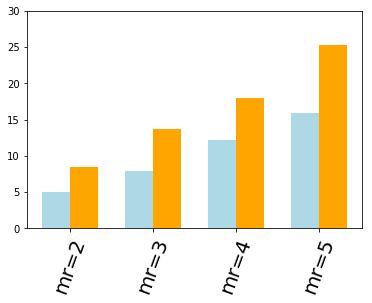

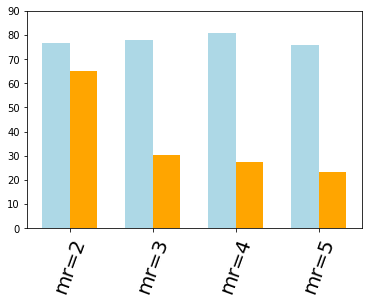

In [103]:
generateRoadAngleBars(['../town-sim-data/r1=2','../town-sim-data/r1=3','../town-sim-data/r1=4','../town-sim-data/r1=5',])

In [84]:
def generateRoadAngleGraph(folderpath):
    folderpaths = []
#     for param in [5, 10, 20, 50]:
#         folderpath = "../town-sim-data/{}={}".format('ma', param)
#         folderpaths.append(folderpath)
#     for param in [100, 400, 800, 1000]:
#         folderpath = "../town-sim-data/{}={}".format('mi', param)
#         folderpaths.append(folderpath)
    for param in [2, 3, 4, 5]:
        folderpath = "../town-sim-data/{}={}".format('r1', param)
        folderpaths.append(folderpath)
    for param in [3, 4, 5, 7]:
        folderpath = "../town-sim-data/{}={}".format('r2', param)
        folderpaths.append(folderpath)
    for param in [6, 8, 10, 12]:
        folderpath = "../town-sim-data/{}={}".format('r3', param)
        folderpaths.append(folderpath)
        
    for folderpath in folderpaths:
        print(folderpath)
        for _, _, filenames in os.walk(folderpath):
            filenames = [f for f in filenames if f.endswith(".p")]

            list_of_degrees_mi = []
            list_of_degrees_ma = [] 

            for f in filenames:
                f = f[:f.index(".p")]
    #             print ("Filename = {}.".format(f))

                filename_state = "{}/{}.p".format(folderpath, f)
                filename_roads = "{}/{}.output.txt".format(folderpath, f)
                filename_stats = "{}/stats_{}.output.txt".format(folderpath, f)

                landscape = Landscape(100, 100, None, 0, 0, 0, 0, load_filename=filename_state) #hard-code size=100
                landscape.set_adjacents()

                list_of_roads = []
                roadnodes = set(copy.copy(landscape.roads))
                for n in sorted(landscape.roads, key=lambda x: (x.x, x.y)):
                    if n not in roadnodes:
                        continue
                    new_road = set([n])
                    new_road_bits = [x for nn in new_road for x in nn.adjacent if len(nn.adjacent & set(landscape.roads)) <= 2 and x in landscape.roads and x not in new_road]
                    while len(new_road_bits) > 0:
                        new_road.update(set(new_road_bits))
                        new_road_bits = [x for nn in new_road_bits for x in nn.adjacent if len(nn.adjacent & set(landscape.roads)) <= 2 and x in landscape.roads and x not in new_road]
                    list_of_roads.append(new_road)
                    roadnodes -= set(new_road)

                for road in list_of_roads:
                    road = list(road)
                    if len(road) >= 2:
                        # sort roadnodes of road according to x val
                        road = sorted(road, key=lambda x: (x.x, x.y))
                        rnode1 = road[0]
                        rnode2 = road[len(road)-1]
                        (x, y) = (rnode2.x - rnode1.x, rnode2.y - rnode1.y)

                        r = math.hypot(x, y)
                        theta = np.arctan2(y, x)
                        theta = math.degrees(theta) % 180
                        if theta == 0:
                            theta = 180
                            
                        if len(road) > 2:                            
                            if Type.MINOR_ROAD in road[-2].type:
                                list_of_degrees_mi.append((r, theta))
                            else:
                                list_of_degrees_ma.append((r, theta))
                        else:
                            if Type.MINOR_ROAD in rnode1.type or Type.MINOR_ROAD in rnode2.type:
                                list_of_degrees_mi.append((r, theta))
                            else:
                                list_of_degrees_ma.append((r, theta))

            list_of_degrees_ma = sorted(list_of_degrees_ma, key=lambda x: x[1])
            list_of_degrees_mi = sorted(list_of_degrees_mi, key=lambda x: x[1])
            directions_ma = set([theta for (r, theta) in list_of_degrees_ma])
            directions_mi = set([theta for (r, theta) in list_of_degrees_mi])
            summed_list_of_degrees_ma = []
            summed_list_of_degrees_mi = []

            for direction in directions_ma:
                dirList = [r for (r, theta) in list_of_degrees_ma if theta == direction]
                magnitude = sum(dirList)/len(filenames)
                summed_list_of_degrees_ma.append((magnitude, direction))
            for direction in directions_mi:
                dirList = [r for (r, theta) in list_of_degrees_mi if theta == direction]
                magnitude = sum(dirList)/len(filenames)
                summed_list_of_degrees_mi.append((magnitude, direction))

            width, height = matplotlib.rcParams['figure.figsize']
            size = min(width, height)

            print (len(filenames))

            fig = plt.figure(figsize=(size, size))
            ax = fig.add_axes([0, 0, 1, 1], polar=True)
            ax.set_rlim(0, 14)

            for r, theta in summed_list_of_degrees_ma:
                ax.plot([math.radians(theta), math.radians(theta)], [0, r], color='#006600', linewidth=2)
            ax.set_thetamin(0)
            ax.set_thetamax(185)
            ax.spines['start'].set_color('#dddddd')
            ax.spines['end'].set_color('#dddddd')
            plt.thetagrids( range(0,185,30), ('0°', '30°', '60°', '90°', '120°', '150°', '180°') )
            plt.show()

            fig = plt.figure(figsize=(size, size))
            ax = fig.add_axes([0, 0, 1, 1], polar=True)
            ax.set_rlim(0, 45)

            for r, theta in summed_list_of_degrees_mi:
                ax.plot([math.radians(theta), math.radians(theta)], [0, r], color='#000088', linewidth=2)
            ax.set_thetamin(0)
            ax.set_thetamax(185)
            ax.spines['start'].set_color('#dddddd')
            ax.spines['end'].set_color('#dddddd')
            plt.thetagrids( range(0,185,30), ('0°', '30°', '60°', '90°', '120°', '150°', '180°') )
            plt.show()

../town-sim-data/r1=2
30


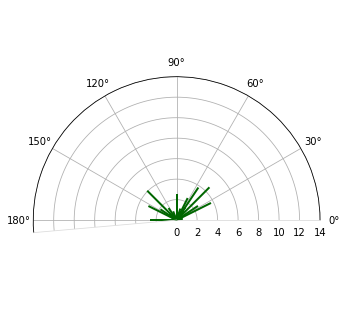

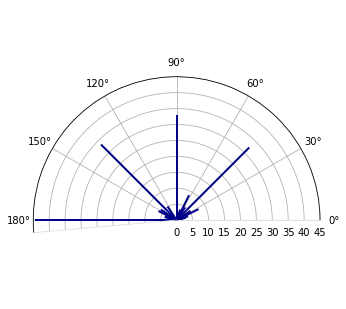

../town-sim-data/r1=3
30


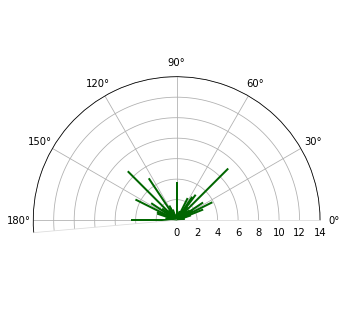

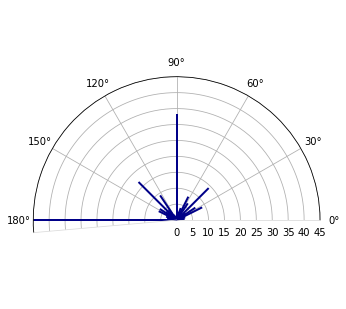

../town-sim-data/r1=4
30


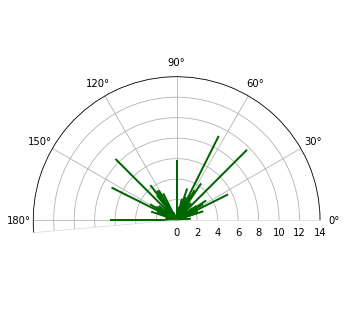

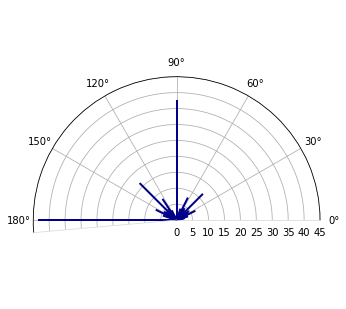

../town-sim-data/r1=5
30


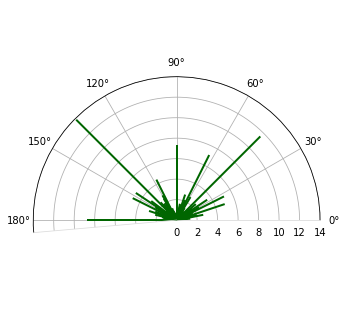

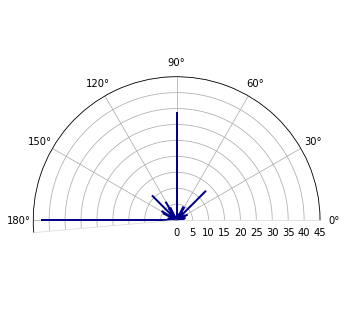

../town-sim-data/r2=3
30


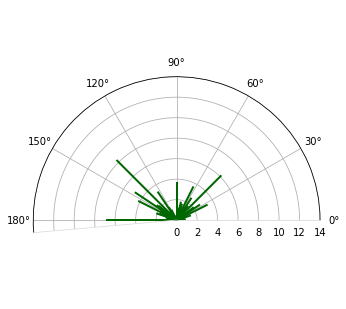

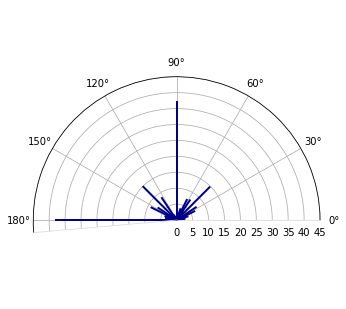

../town-sim-data/r2=4
30


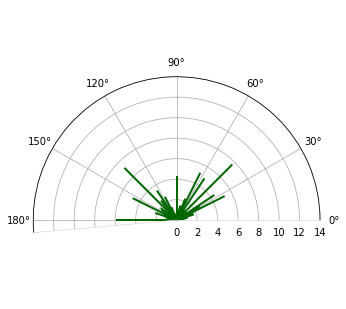

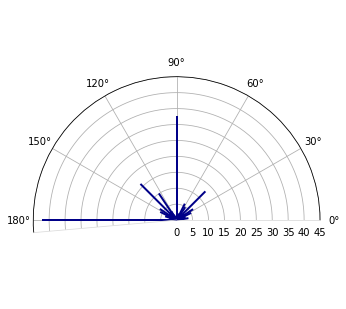

../town-sim-data/r2=5
30


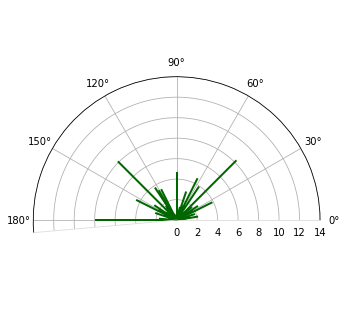

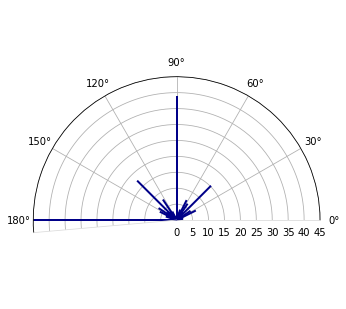

../town-sim-data/r2=7
30


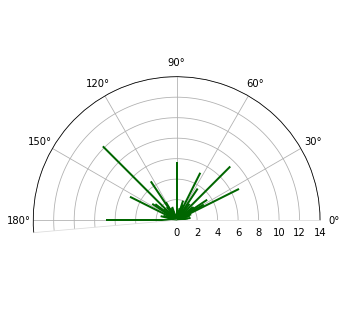

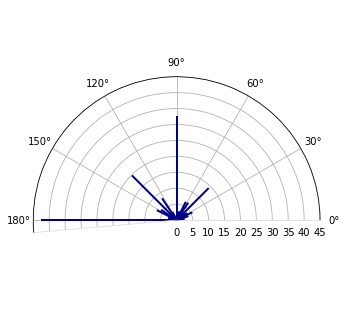

../town-sim-data/r3=6
30


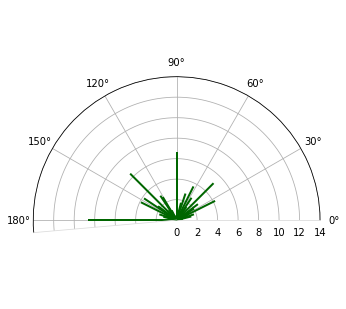

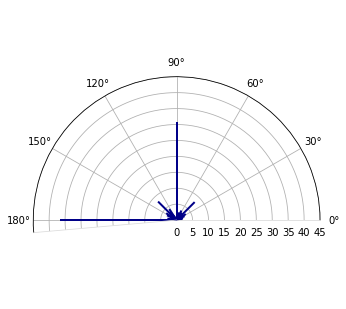

../town-sim-data/r3=8
30


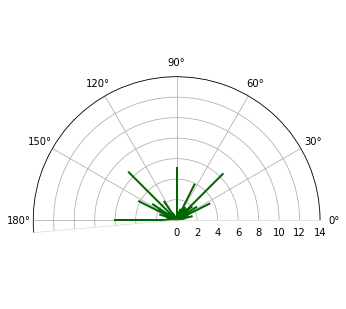

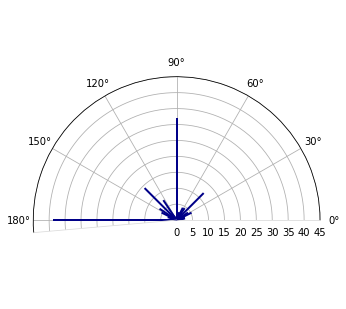

../town-sim-data/r3=10
30


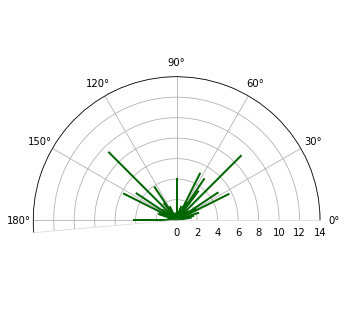

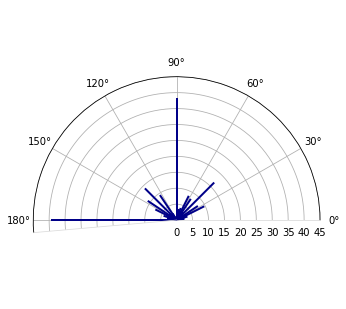

../town-sim-data/r3=12
30


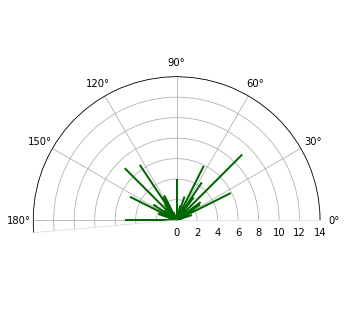

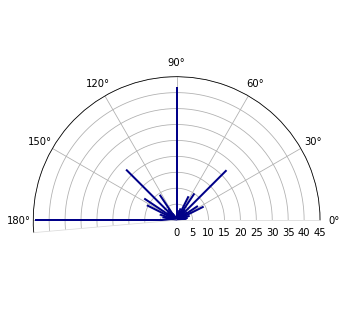

In [85]:
generateRoadAngleGraph("")

In [37]:
def generateConnectivityGraph(folderpath):
    for _, _, filenames in os.walk(folderpath):
        filenames = [f for f in filenames if f.endswith(".p")]
        
        connectivity = []
        local_depth = []
        global_depth = []

        for f in filenames:
            f = f[:f.index(".p")]
#             print ("Filename = {}.".format(f))

            filename_state = "{}/{}.p".format(folderpath, f)
            filename_roads = "{}/{}.output.txt".format(folderpath, f)
            filename_stats = "{}/stats_{}.output.txt".format(folderpath, f)
            
            # skip first two numbers x and y, match next 3 numbers
            p = re.compile("\D+\d+\D+\d+\D+(\d+)\D+(\d+)\D+(\d+)\D+") 
            
            with open(filename_stats, "rb") as file:
                line = file.readline()
                c = []
                l = []
                g = []
                while line:
                    m = p.match(str(line))
                    connectivity.append(int(m.groups()[0]))
                    local_depth.append(int(m.groups()[1]))
                    global_depth.append(int(m.groups()[2]))
                    line = file.readline()
        
        data = local_depth
        fig1, ax1 = plt.subplots()

        ax1.hist([data], int(max(data)), alpha=0.75, orientation='horizontal', log=True)
        ax1.set_ylim(0, 40)
        plt.show()
    
        data = global_depth
        fig1, ax1 = plt.subplots()
        ax1.hist([data], 90, alpha=0.75, orientation='horizontal', log=True)
        ax1.set_ylim(0, 400)
        plt.show()


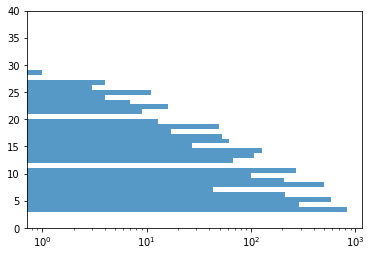

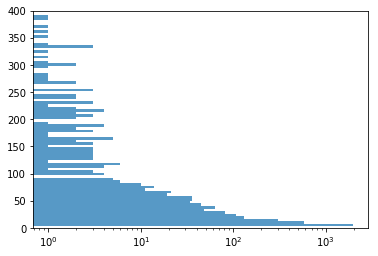

In [50]:
generateConnectivityGraph("../town-sim-data/r2=7")

In [58]:
def generateCurvinessGraph(folderpath):
    for _, _, filenames in os.walk(folderpath):
        filenames = [f for f in filenames if f.endswith(".p")]

        curvature_list = []
        for f in filenames:
            f = f[:f.index(".p")]
#             print ("Filename = {}.".format(f))

            filename_state = "{}/{}.p".format(folderpath, f)
            filename_roads = "{}/{}.output.txt".format(folderpath, f)
            filename_stats = "{}/stats_{}.output.txt".format(folderpath, f)

            landscape = Landscape(100, 100, None, 0, 0, 0, 0, load_filename=filename_state) #hard-code size=100
            landscape.set_adjacents()
#             array = np.ones((len(landscape.array), len(landscape.array[0])))
#             array *= -1


#             for i in range(100):
#                 for j in range(100):
#                     if landscape.array[i][j] in landscape.roads:
#                         array[i][j] = 0

            list_of_roads = []
            roadnodes = set(copy.copy(landscape.roads))
            for n in sorted(landscape.roads, key=lambda x: (x.x, x.y)):
                if n not in roadnodes:
                    continue
                new_road = set([n])
                new_road_bits = [x for nn in new_road for x in nn.adjacent if len(nn.adjacent & set(landscape.roads)) <= 2 and x in landscape.roads and x not in new_road]
                while len(new_road_bits) > 0:
                    new_road.update(set(new_road_bits))
                    new_road_bits = [x for nn in new_road_bits for x in nn.adjacent if len(nn.adjacent & set(landscape.roads)) <= 2 and x in landscape.roads and x not in new_road]
                list_of_roads.append(new_road)
                roadnodes -= set(new_road)

            for road in list_of_roads:
                road = list(road)
                if len(road) > 2:
                    # sort roadnodes of road according to x val
                    road = sorted(road, key=lambda x: (x.x, x.y))
                    x = np.array([n.x for n in road])
                    y = np.array([n.y for n in road])
                    dx_dt = np.gradient(x)
                    dy_dt = np.gradient(y)
                    d2x_dt2 = np.gradient(dx_dt)
                    d2y_dt2 = np.gradient(dy_dt)
                    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
                    curvature_list.append((sum(curvature), len(road)))

        curvatures = set([x[0] for x in curvature_list])
        new_curvature_list = []
        for c in curvatures:
            new_curvature_list.append((c, sum([x[1] for x in curvature_list if x[0] == c])))
        maxcolor = 3.9908035449766794
        new_curvature_list = sorted(new_curvature_list, key=lambda x:x[0])
        cmap = matplotlib.cm.get_cmap('nipy_spectral')

        fig, ax = plt.subplots(figsize=(1, 5))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.axis('off')

#             for road in list_of_roads:
#                 road = list(road)
#                 if len(road) > 2:
#                     # sort roadnodes of road according to x val
#                     road = sorted(road, key=lambda x: (x.x, x.y))
#                     x = np.array([n.x for n in road])
#                     y = np.array([n.y for n in road])
#                     dx_dt = np.gradient(x)
#                     dy_dt = np.gradient(y)
#                     d2x_dt2 = np.gradient(dx_dt)
#                     d2y_dt2 = np.gradient(dy_dt)
#                     curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
#                     for n in road:
#                         array[n.x][n.y] = sum(curvature)/maxcolor

        curr=None
        for c in new_curvature_list:
            if curr is None:
                curr = [0]
            color = ((c[0]/maxcolor) + 0.1) / 1.2
            color = cmap(color)

            plt.bar([0], [c[1]], color=color, bottom=curr)
            curr = [curr[0] + c[1]]

#             plt.imshow(array, cmap=plt.cm.nipy_spectral, vmin=-0.1, vmax=1.1)

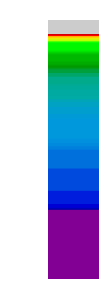

In [64]:
generateCurvinessGraph('../town-sim-data/co=1')

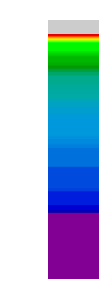

In [65]:
generateCurvinessGraph('../town-sim-data/co=3')

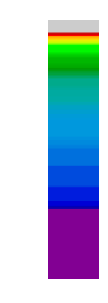

In [66]:
generateCurvinessGraph('../town-sim-data/co=5')

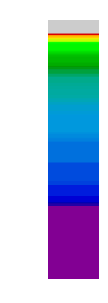

In [69]:
generateCurvinessGraph('../town-sim-data/dp=0.9')

In [12]:
def constructTownSimMapFrom(imgpath):
    im = cv2.imread(imgpath)
    (y, x, _) = im.shape
    landscape = Landscape(x, y, None, 3, 5, 10, 10)

    for i in range(x):
        for j in range(y):
            landscape.array[i][j].clear_type()
            if im[j][i][0] == 0:
                landscape.array[i][j].add_type(Type.MINOR_ROAD)
                #not distinguishing between major & minor here
                landscape.roads.append(landscape.array[i][j])
#                 landscape.set_type_road([(i, j)], Type.MINOR_ROAD)
    return landscape
    

In [41]:
def generateCurvinessGraphFromImg(f, list_of_roads):
    landscape = constructTownSimMapFrom(f)
    landscape.set_adjacents()

    curvature_list = []

    array = np.ones((len(landscape.array), len(landscape.array[0])))
    array *= -1

    for i in range(800):
        for j in range(800):
            if landscape.array[i][j] in landscape.roads:
                array[i][j] = 0
        

    for road in list_of_roads:
        road = list(road)
        if len(road) > 2:
            # sort roadnodes of road according to x val
            road = sorted(road, key=lambda x: (x.x, x.y))
            x = np.array([n.x for n in road])
            y = np.array([n.y for n in road])
            dx_dt = np.gradient(x)
            dy_dt = np.gradient(y)
            d2x_dt2 = np.gradient(dx_dt)
            d2y_dt2 = np.gradient(dy_dt)
            curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
            curvature_list.append((sum(curvature), len(road)))

    curvatures = set([x[0] for x in curvature_list])
    new_curvature_list = []
    for c in curvatures:
        new_curvature_list.append((c, sum([x[1] for x in curvature_list if x[0] == c])))
#     maxcolor = 3.9908035449766794
    maxcolor = statistics.mean(curvatures) + 2 * statistics.stdev(curvatures)
#     maxcolor = max(new_curvature_list, key=lambda x:x[0])[0]
    print(new_curvature_list)
    print(maxcolor)
    new_curvature_list = sorted(new_curvature_list, key=lambda x:x[0])
    cmap = matplotlib.cm.get_cmap('nipy_spectral')

    fig, ax = plt.subplots(figsize=(1, 5))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axis('off')

    for road in list_of_roads:
        road = list(road)
        if len(road) > 2:
            # sort roadnodes of road according to x val
            road = sorted(road, key=lambda x: (x.x, x.y))
            x = np.array([n.x for n in road])
            y = np.array([n.y for n in road])
            dx_dt = np.gradient(x)
            dy_dt = np.gradient(y)
            d2x_dt2 = np.gradient(dx_dt)
            d2y_dt2 = np.gradient(dy_dt)
            curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
            for n in road:
                array[n.x][n.y] = sum(curvature)/maxcolor

    curr=None
    for c in new_curvature_list:
        if curr is None:
            curr = [0]
        color = ((c[0]/maxcolor) + 0.1) / 1.2
        color = cmap(color)

        plt.bar([0], [c[1]], color=color, bottom=curr)
        curr = [curr[0] + c[1]]

    plt.imshow(array, cmap=plt.cm.nipy_spectral, vmin=-0.1, vmax=1.1)

In [53]:
def getRoadListFromImg(f):
    landscape = constructTownSimMapFrom(f)
    landscape.set_adjacents()
    
    list_of_roads = []
    roadnodes = set(copy.copy(landscape.roads))
    print(len(roadnodes))
    sortedroadnodes = sorted(landscape.roads, key=lambda x: (x.x, x.y))
    print(len(sortedroadnodes))
    for i in range(len(sortedroadnodes)):
        if i % 100 == 0:
            print("i = {}".format(i))
        n = sortedroadnodes[i]
        if n not in roadnodes:
            continue
        new_road = set([n])
        new_road_bits = [x for nn in new_road for x in nn.adjacent if len(nn.adjacent & set(landscape.roads)) <= 3 and x in landscape.roads and x not in new_road]
        while len(new_road_bits) > 0:
            new_road.update(set(new_road_bits))
            new_road_bits = [x for nn in new_road_bits for x in nn.adjacent if len(nn.adjacent & set(landscape.roads)) <= 3 and x in landscape.roads and x not in new_road]
        list_of_roads.append(new_road)
        roadnodes -= set(new_road)
        
    return list_of_roads



In [ ]:
generateCurvinessGraphFromImg('../real-cities/pixelized/pixelized-cropped-berlin-innermost-ring-road.png', roadlist)

In [ ]:
# roadlist = getRoadListFromImg('../real-cities/pixelized/pixelized-cropped-berlin-innermost-ring-road.png')